# Home Credit - Credit Risk Model Stability Project

## Abstract

The goal of this project is to accurately predict which clients are likely to default on their loans. Loan defaults pose significant financial risks to consumer finance providers, impacting their profitability and stability. Traditional methods of assessing default risk often rely on historical data and conventional credit scoring models, which may not fully capture the complexities of an individual's financial behavior over time. By leveraging advanced machine learning techniques, this project seeks to develop more reliable and robust models for predicting loan defaults.

This endeavor is crucial as it offers consumer finance providers a tool to better assess the risk associated with potential clients, leading to more informed lending decisions. Improved prediction models can help reduce the incidence of loan defaults, thereby enhancing the financial health of lending institutions. Additionally, stable and accurate risk assessments can contribute to fairer lending practices, as they are likely to identify creditworthy clients who might be overlooked by traditional methods. This project not only aims to enhance the accuracy of default predictions but also emphasizes the importance of model stability over time, ensuring that the solutions are sustainable and effective in the long run.

### Accomplishments:

1. Ability to work with highly imbalanced data and perform different types of missing value imputations to enhance model performance:
    A significant discovery during our investigation was the profound impact that missing value imputation had on model performance. Given that approximately 92% of our dataset contained missing values, robust imputation strategies were essential(mean and mode imputation, knn imputation, binary indicators) significantly improved the model's ability to handle incomplete data.
    This approach not only filled the gaps in the dataset but also provided additional signals that the model could leverage to make more accurate predictions.
2. Effectivenes of SMOTE in addressing class imbalance:
    By generating synthetic samples for the minority class, SMOTE significantly improved the recall of the minority class predictions without overly compromising precision. This balancing act was pivotal in ensuring that the model could identify true positives more reliably. Our iterative evaluation showed a substantial increase in the recall metric, indicating that the model became much better at identifying positive instances in the imbalanced dataset.

## Introduction

Our project aims to develop a robust model for predicting loan defaults using a highly imbalanced dataset from a Kaggle competition hosted by Home Credit ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview)). This dataset includes over 1.5 million cases with a binary target variable indicating default (positive class) or no default (negative class). The data spans various financial and socio-economic features, sourced from multiple tables, with a significant imbalance (97% no default, 3% default) and a high percentage of missing values (92%). The primary research question is: Can we create a stable, accurate predictive model that effectively identifies clients likely to default on loans?

### Importance and Research Plan
Predicting loan defaults accurately is crucial for financial institutions as it directly impacts their risk management strategies and financial stability. Improved prediction models can reduce financial losses and help institutions make more informed lending decisions, ultimately contributing to a healthier financial ecosystem.

#### Key Results

Key results include significant improvements in precision and recall metrics by using the LightGBM model. This demonstrates our model’s enhanced ability to identify true positive cases of loan defaults, despite the challenges posed by the dataset's imbalance and missing values.

## Background

## Data

As stated above, our dataset comes from the Kaggle Competition - Credit Risk Model Stability hosted by Home Credit, an international consumer finance provider. The data can be obtained by entering the command line (install Kaggle first):
```bash
kaggle competitions download -c home-credit-credit-risk-model-stability
```

The dataset is spread across 17 tables (1 base table + 16 data tables). It is split between training data with over 1.5 million cases, and testing data with 10 cases and no target labels. Our training and testing sets were taken from the training data provided as the test set could not provide us with any evaluation metrics and was too small.

In [3]:
# Directory to data
data_root = '../data/raw/csv_files/train'

### Base Table

In [8]:
import os
import pandas as pd

# Visualization functions
import utils.viz_tools as viz_tools

In [9]:
base_table = 'train_base.csv'
base_df = pd.read_csv(os.path.join(data_root, base_table))
base_df['date_decision'] = pd.to_datetime(base_df['date_decision'])

With the base table we can inspect the composition of the classes. A class imbalance of 97-to-3 in favor of the negative case (no default) is a very imbalanced dataset.

In [10]:
# Total cases
n_total = len(base_df)

# Number of negative cases
n_neg = len(base_df[base_df['target'] == 0])

# Number of positive cases
n_pos = len(base_df[base_df['target'] == 1])

print('Number of total cases:', n_total)
print(f'Negative cases: Count - {n_neg}, Percentage - {100*n_neg/n_total:.2f}%')
print(f'Positive cases: Count - {n_pos}, Percentage - {100*n_pos/n_total:.2f}%')

Number of total cases: 1526659
Negative cases: Count - 1478665, Percentage - 96.86%
Positive cases: Count - 47994, Percentage - 3.14%


The base table also contained another very relevant feature, `date_decision`. As we are trying to predict *future* applicant cases, the test set must be taken from the latest decision dates.

The `date_decision` also contains trends on how often cases default.

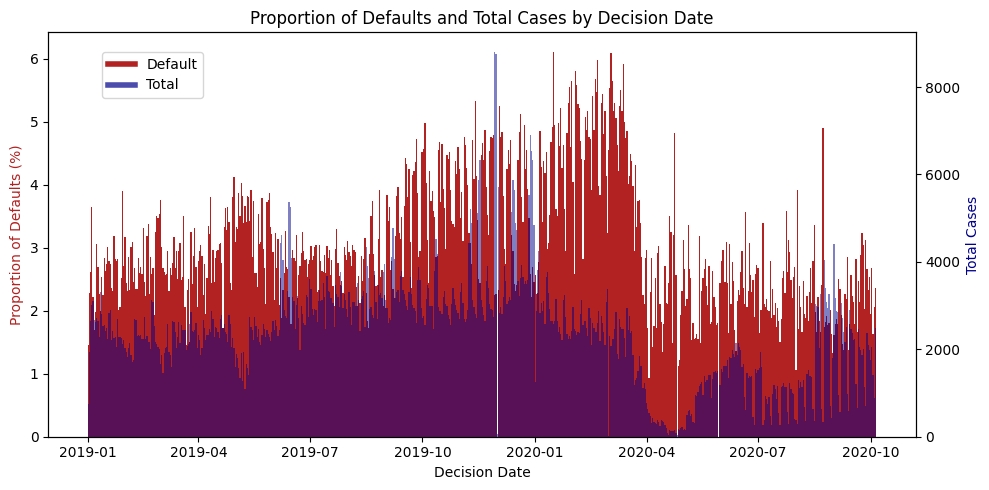

In [11]:
# Get proportion of defaults by date
date_target_prop = base_df.groupby('date_decision')['target'].value_counts(normalize=True).reset_index()
date_target_prop = date_target_prop[date_target_prop['target'] == 1]
date_target_prop['proportion'] = 100 * date_target_prop['proportion']

# Get number of decisions by date
date_total = base_df.groupby('date_decision')['target'].count().reset_index()

# Plot
viz_tools.two_bars_share_x(df1=date_target_prop, df2=date_total,
                          x_name='date_decision', y1_name='proportion',
                          y2_name='target', x_label='Decision Date',
                          title='Proportion of Defaults and Total Cases by Decision Date',
                          y1_label='Proportion of Defaults (%)',
                          y2_label='Total Cases', l1_label='Default',
                          l2_label='Total')

### Data Tables

We have 16 data tables containing static and transactional data stored as categorical data, numerical data, and dates. These tables are further broken down into 3 different depths.

- Depth 0 tables are indexed by the `case_id` alone and primarily include static data such as date of birth.
- Depth 1 tables are indexed by `case_id` and `num_group1` and contain historical data and possible associated parties.
- Depth 2 tables are index by `case_id`, `num_group1`, and `num_group2` while also containing historical data and possible associated parties.

![Tables](figures/tables.jpg)

Of particular note, when `num_group1` is equal to *0*, the data is directly associated with the current applicant of the loan.

In order to predict by case, we needed to aggregate data by `case_id` in the depth 1 and depth 2 tables.

### Data Preprocessing

We separated the data by the current applicant data and non-current applicant data (`num_group1` is not equal to *0*). From there, we applied multiple different aggregations grouping by `case_id`.

- Categorical: we retrieved the mode and applied both binary encoding to reduce the number of columns (versus one-hot encoding) and frequency encoding, to indicate the frequency of the category.
- Numerical: mean, min, max, median, and sum.
- Date: min and max.

![Aggs](figures/aggs.jpg)

From the aggregated data, we decided to subsample the dataset for the training data where the minority class (default) was weighted more heavily at a ratio of 5-to-1.  Additionally, the test set was a holdout of the last 10000 cases in the dataset.

In [13]:
import utils.merge_tools as merge_tools

## Methods

## Evaluation

## Conclusion

## Attribution

## Bibliography

## Appendix